In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

def getNCells(expMat):
    return len(expMat)

def getFlPerCell(expMat):
    return np.mean(np.sum(expMat, axis=1))

def getComplexity(expMat):
    total_sum = np.sum(expMat)
    row_sums = np.sum(expMat, axis=1)
    cum_sums = np.cumsum(row_sums)
    return (list(np.where(cum_sums >= (total_sum / 2))[0])[0] + 1) / np.shape(expMat)[0]

def getEntropy(expMat):

    def atom_entropy(x):
        x = np.array(x)  # Convert to NumPy array if not already
        zero_mask = (x == 0)
        if np.any(zero_mask):
            x[zero_mask] = 0  # Set entropy to 0 for elements equal to 0
        non_zero_mask = ~zero_mask
        if np.any(non_zero_mask):
            x[non_zero_mask] = x[non_zero_mask] * np.log2(x[non_zero_mask])
        return x

    expMat = expMat.flatten().astype(int)
    table = np.bincount(expMat) / len(expMat)
    return -np.sum(atom_entropy(table))

def getSparsity(expMat):
    count = 0
    for j in range(np.shape(expMat)[1]):
        col = expMat[:,j]
        std_col = np.std(col)
        mean_col = np.mean(col)
        thresh = mean_col - (2*std_col)
        for k in col:
            if k < thresh:
                count = count+1
    return count/expMat.size

def getMeanSNR(expMat):
    tempSNR = []
    for j in range(np.shape(expMat)[1]):
        sorted_arr = np.sort(expMat[:,j])
        top20 = sorted_arr[-int(len(sorted_arr)*0.2):]
        bottom10 = sorted_arr[:int(len(sorted_arr*0.1))]
        tempSNR.append(np.mean(top20)/np.mean(bottom10))
    return np.mean(tempSNR)

In [2]:
# initialize a df sheet to store db info
master_path = 'TOUCHSTONE_CP/'
samples = sorted([s for s in os.listdir(master_path) if "TOUCHSTONE" in s])
column_names = ['sample_id', 'tissue', 'disease', 'nCells', 'flPerCell', 'complexity', 'entropy', 'sparsity', 'meanSNR']
df_proteinDB = pd.DataFrame(columns= column_names)
df_proteinDB['sample_id'] = samples

for i in range(len(samples)):
    sample_path = os.path.join(master_path, samples[i])
    files = os.listdir(sample_path)
    # figure out which is the expMat
    for file in files:
        if 'exprMat' in file:
            expMat_path = os.path.join(sample_path, file)
            break
    # initialize the expMat
    df_expMat = pd.read_csv(expMat_path)
    columns_to_remove = ['fov', 'cell_ID']
    df_expMat = df_expMat.drop(columns_to_remove, axis=1)
    df_expMat = df_expMat.drop(df_expMat.columns[df_expMat.columns.str.contains('Channel', case=False)], axis=1)
    expMat = df_expMat.values

    # figure out the tissue
    df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'tissue'] = samples[i].split('_')[4]

    # figure out the disease
    if samples[i].split('_')[4] != 'PR':
        df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'disease'] = 'normal'
    else:
        df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'disease'] = 'cancer'
        
    # calculate the metrics
    df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'nCells'] = getNCells(expMat=expMat)
    df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'flPerCell'] = getFlPerCell(expMat=expMat)
    df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'complexity'] = getComplexity(expMat=expMat)
    df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'entropy'] = getEntropy(expMat=expMat)
    df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'sparsity'] = getSparsity(expMat=expMat)
    df_proteinDB.loc[df_proteinDB['sample_id'] == samples[i], 'meanSNR'] = getMeanSNR(expMat=expMat)

df_proteinDB.to_csv('ProteinDB.csv', index=False)

/tmp/ipykernel_2172467/1970775870.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proteinDB, x='tissue', y=col, ax=ax, palette='Set2')
/tmp/ipykernel_2172467/1970775870.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proteinDB, x='tissue', y=col, ax=ax, palette='Set2')
/tmp/ipykernel_2172467/1970775870.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proteinDB, x='tissue', y=col, ax=ax, palette='Set2')
/tmp/ipykernel_2172467/1970775870.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is 

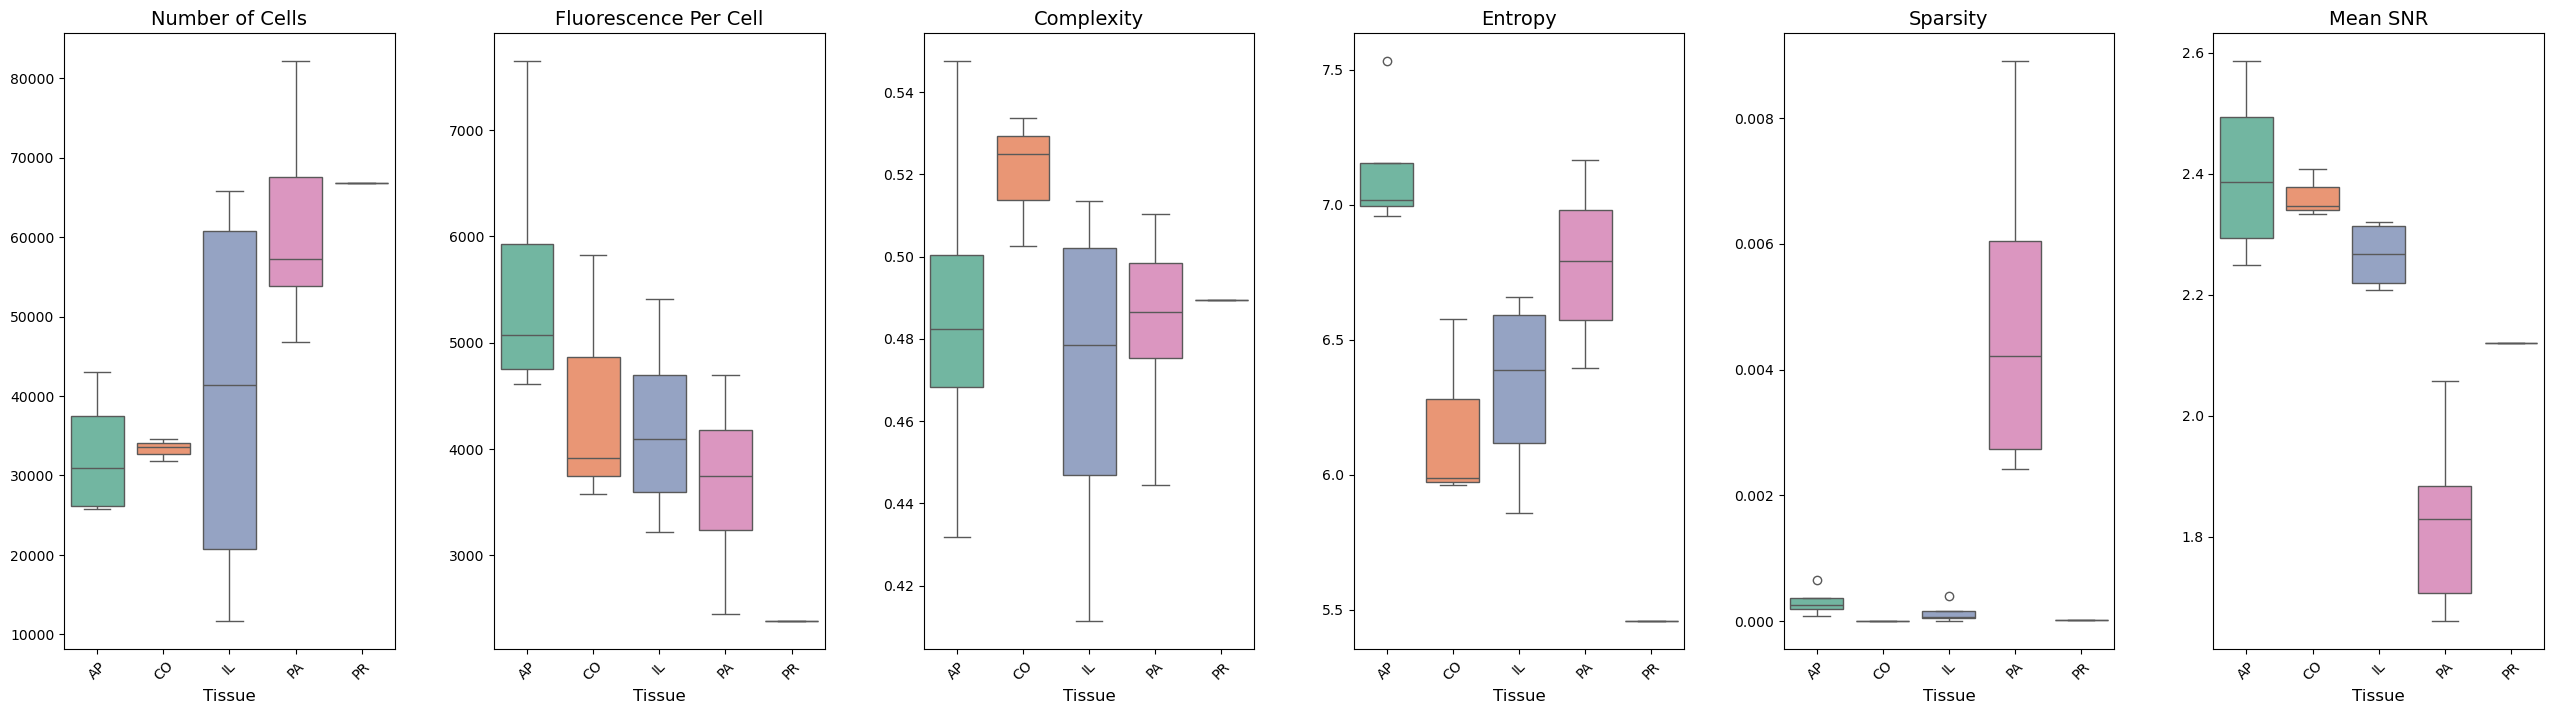

In [3]:
# Assuming you have a DataFrame named 'df' with the specified columns
numeric_columns = ['nCells', 'flPerCell', 'complexity', 'entropy', 'sparsity', 'meanSNR']
metric_names = ['Number of Cells', 'Fluorescence Per Cell', 'Complexity', 'Entropy', 'Sparsity', 'Mean SNR']
tissues = df_proteinDB['tissue'].unique()

# Create a figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(32, 8))
axes = axes.flatten()  # Flatten the axes into a 1D array

# Iterate over numeric columns and axes
for i, (col, ax) in enumerate(zip(numeric_columns, axes)):
    # Create a box plot for each tissue
    sns.boxplot(data=df_proteinDB, x='tissue', y=col, ax=ax, palette='Set2')
    ax.set_title(metric_names[i], fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Tissue', fontsize=12)
    ax.set_ylabel('') 

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)
# plt.suptitle('Protein Metrics for Touchstone Samples', fontsize=18)

# Show the plot
plt.savefig('FIGURE5A.pdf', format="pdf", bbox_inches="tight")

In [4]:
results = {}
for tissue in df_proteinDB['tissue'].unique():
    results[tissue] = {}
    for metric in numeric_columns:
        # Filter the DataFrame for the current tissue
        tissue_df = df_proteinDB[df_proteinDB['tissue'] == tissue]
        
        # Store the results in the dictionary
        results[tissue][metric] = {
            'min': tissue_df[metric].min(),
            'max': tissue_df[metric].max(),
            'q1': tissue_df[metric].quantile(0.25),
            'q3': tissue_df[metric].quantile(0.75),
            'mean': tissue_df[metric].mean(),
            'median': tissue_df[metric].median(),
            'std': tissue_df[metric].std()
        }

# Create an HTML file and write the results
with open('ProteinMetricsSummary.html', 'w') as file:
    file.write('<html><body>')
    file.write('<h1>Protein Metrics Summay Statistics</h1>')
    file.write('<table>')
    file.write('<tr><th>Metric</th>')
    for tissue in tissues:
        file.write(f'<th>{tissue}</th>')
    file.write('</tr>')
    for metric in numeric_columns:
        file.write(f'<tr><td>{metric}</td>')
        for tissue in tissues:
            stats = results[tissue][metric]
            file.write(f'<td>Min: {stats["min"]:.2f}<br>Max: {stats["max"]:.2f}<br>Q1: {stats["q1"]:.2f}<br>Q3: {stats["q3"]:.2f}<br>Mean: {stats["mean"]:.2f}<br>Median: {stats["median"]:.2f}<br>Std: {stats["std"]:.2f}</td>')
        file.write('</tr>')
    file.write('</table>')
    file.write('</body></html>')

In [5]:
results = {}
for d in df_proteinDB['disease'].unique():
    results[d] = {}
    for metric in numeric_columns:
        # Filter the DataFrame for the current disease
        disease_df = df_proteinDB[df_proteinDB['disease'] == d]
        
        # Store the results in the dictionary
        results[d][metric] = {
            'min': disease_df[metric].min(),
            'max': disease_df[metric].max(),
            'q1': disease_df[metric].quantile(0.25),
            'q3': disease_df[metric].quantile(0.75),
            'mean': disease_df[metric].mean(),
            'median': disease_df[metric].median(),
            'std': disease_df[metric].std()
        }

diseases = ['normal', 'cancer']

# Create an HTML file and write the results
with open('ProteinMetricsSummary_Disease.html', 'w') as file:
    file.write('<html><body>')
    file.write('<h1>Protein Metrics Summay Statistics</h1>')
    file.write('<table>')
    file.write('<tr><th>Metric</th>')
    for d in diseases:
        file.write(f'<th>{d}</th>')
    file.write('</tr>')
    for metric in numeric_columns:
        file.write(f'<tr><td>{metric}</td>')
        for d in diseases:
            stats = results[d][metric]
            file.write(f'<td>Min: {stats["min"]:.2f}<br>Max: {stats["max"]:.2f}<br>Q1: {stats["q1"]:.2f}<br>Q3: {stats["q3"]:.2f}<br>Mean: {stats["mean"]:.2f}<br>Median: {stats["median"]:.2f}<br>Std: {stats["std"]:.2f}</td>')
        file.write('</tr>')
    file.write('</table>')
    file.write('</body></html>')